# 使用Logistic Regression做CTR预估

Let's say that you're a major search engine, and you need to decide which ad to display at the top of your search results. How would you do it?

Your first thought might be to narrow the scope to ads "related" to the search, and then choose whichever ad offers the greatest revenue. Companies have already bid on how much they will pay you, so it seems easy to maximize your revenue by choosing the highest paying ad. But is that the right approach?

Many ads are actually sold on a "pay-per-click" (PPC) basis, meaning the company only pays for ad clicks, not ad views. Thus your optimal approach (as a search engine) is actually to choose an ad based on "expected value", meaning the price of a click times the likelihood that the ad will be clicked. In other words, a \$1.00 ad with a 5% probability of being clicked has an expected value of \$0.05, whereas a \$2.00 ad with a 1% probability of being clicked has an expected value of only \$0.02. In this case, you would choose to display the first ad.

In order for you to maximize expected value, you therefore need to accurately predict the likelihood that a given ad will be clicked, also known as "click-through rate" (CTR).

In this notebook, I'll walk through the predictive modeling process, discuss why logistic regression is a good choice for this task, and then explain this code line-by-line so that you can apply it to your own predictive task!

For this example, I'm using the data from a [Kaggle competition](https://www.kaggle.com/c/avazu-ctr-prediction) on click-through rate prediction sponsored by Avazu. The goal in the competition matches our goal, which is to predict the likelihood that a given ad will be clicked.

## Step 1: Reading and Exploring the Data

I've already downloaded the dataset from Kaggle for this example and extracted a small subset to make my calculations faster. If you would like to follow along, you should download and decompress `train.gz` from the [competition's data page](https://www.kaggle.com/c/avazu-ctr-prediction/data) (login required), and then extract the first 100,000 lines from `train.csv` using this command at the command line/terminal: `head -n100000 train.csv > train_subset.csv`

Our first step is to read the data into an SFrame, which is GraphLab's tabular data structure that is similar to a data frame in R or a pandas DataFrame in Python.

This data happens to be stored in the popular CSV (comma separated value) format, but SFrames can be constructed from a variety of [sources](https://turi.com/products/create/docs/graphlab.data_structures.html#connectors). We'll use the [read_csv](https://turi.com/products/create/docs/generated/graphlab.SFrame.read_csv.html) method to read in the data:

In [2]:
import pandas as pd
data = pd.read_csv('train_small.csv', verbose=False)
# test = pd.read_csv('test.csv')
# data = pd.concat([train,test],axis=1)
# import graphlab as gl
# data = gl.SFrame.read_csv('train_subset.csv', verbose=False)
data.shape

(99999, 24)

Let's take a quick look at the first row of data, to see what we're working with:

In [2]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 24 columns):
id                  99999 non-null float64
click               99999 non-null int64
hour                99999 non-null int64
C1                  99999 non-null int64
banner_pos          99999 non-null int64
site_id             99999 non-null object
site_domain         99999 non-null object
site_category       99999 non-null object
app_id              99999 non-null object
app_domain          99999 non-null object
app_category        99999 non-null object
device_id           99999 non-null object
device_ip           99999 non-null object
device_model        99999 non-null object
device_type         99999 non-null int64
device_conn_type    99999 non-null int64
C14                 99999 non-null int64
C15                 99999 non-null int64
C16                 99999 non-null int64
C17                 99999 non-null int64
C18                 99999 non-null int64
C19                

From Kaggle's [data dictionary](https://www.kaggle.com/c/avazu-ctr-prediction/data), I know that click=0 means the ad was not clicked, and click=1 means the ad was clicked. The "click" column is therefore our target variable, and the other columns are our potential features!

The first thing we want to know is what percentage of ads in the dataset were actually clicked. In this case, we can simply take the mean of the "click" column, since that is equivalent to adding up all of the ones (which is the number of clicks) and dividing by the total number of ads:

In [4]:
data['click'].mean()

0.17490174901749017

We see that 17.5% of the ads were clicked, meaning the overall click-through rate is 17.5%. This is useful to keep in mind as a "baseline", as we'll see later on.

Before we start building a machine learning model, it's always useful to explore the dataset. One way to get started is by using the GraphLab Canvas, a browser-based visualization platform:

In [ ]:
# gl.canvas.set_target('ipynb')
# data.show()

I noticed that "device_type" only has 4 unique values, and it makes intuitive sense that the type of device you're using when viewing an ad might affect your likelihood of clicking the ad, so let's explore it further.

To understand the relationship between this feature and the target variable, we want to calculate the click-through rate for each value of device_type. We can accomplish this by "grouping the data" by device_type, and then calculating the mean of the click column for each group:

In [5]:
# data.groupby('device_type', {'CTR':gl.aggregate.MEAN('click')})
hist = data['click'].groupby(data['device_type']).mean()
import matplotlib.pyplot as plt
plt.bar(hist.index,hist)
hist

device_type
0    0.227499
1    0.175978
4    0.072508
5    0.099057
Name: click, dtype: float64

We saw earlier that the baseline click-through rate is 17.5%, and it appears that there is a big difference in average click-through rate depending on device_type. This looks like a good feature!

Similarly, the C1 column looks like a good feature:

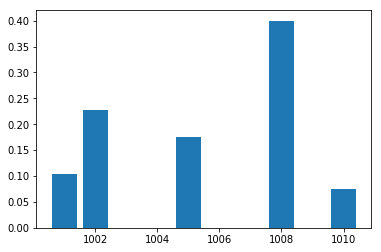

C1
1001    0.103448
1002    0.227499
1005    0.176174
1007    0.000000
1008    0.400000
1010    0.074271
Name: click, dtype: float64

In [6]:
# data.groupby('C1', {'CTR':gl.aggregate.MEAN('click')})
hist = data['click'].groupby(data['C1']).mean()
plt.bar(hist.index,hist)
plt.show()
hist

I also noticed that C15 and C16 appear to be the dimensions of the ad (width and height), which we would also imagine are good predictors of whether an ad is clicked:

In [7]:
data['C15'].value_counts()

320    95132
300     3935
216      912
728       18
120        2
Name: C15, dtype: int64

In [8]:
data['C16'].value_counts()

50     95620
250     3427
36       912
480       20
90        18
20         2
Name: C16, dtype: int64

For our initial model, we'll just use device_type, C1, C15, and C16 as our features.

Note that when we built the SFrame from the CSV file, it simply guessed the data type of each column. Sometimes these data types need to be adjusted, so let's take a quick look at the column names and their associated types to see if there's anything we need to fix:

In [9]:
import numpy as np
pd.DataFrame(list(zip(data.columns, data.dtypes)))

,0,1
0,id,float64
1,click,int64
2,hour,int64
3,C1,int64
4,banner_pos,int64
5,site_id,object
6,site_domain,object
7,site_category,object
8,app_id,object
9,app_domain,object


We know that both device_type and C1 are "categorical variables", meaning that their numerical values represent categories. We'll convert the data type of both of those columns from integer to string, because we don't want our machine learning model to think there is a mathematical relationship between the category values:

In [10]:
data['device_type'] = data['C1'].astype(str)
data['C1'] = data['C1'].astype(str)

In [11]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1005,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1005,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1005,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1005,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1005,0,18993,320,50,2161,0,35,-1,157


You could spend a lot more time on the exploratory phase, but let's move along to the next step in predictive modeling! If you want to learn how to manipulate SFrames in more depth, read through this example notebook, [Introduction to SFrames](https://turi.com/learn/gallery/notebooks/introduction_to_sframes.html).

## Step 2: Splitting the Data

One of the keys to proper machine learning is model evaluation. The goal of model evaluation is to estimate how well your model will "generalize" to future data. In other words, we want to build a model that accurately predicts the future, not the past!

One of the most common evaluation procedures is to split your data into a "training set" and a "testing set". 

Let's use an 80/20 split, in which 80% of the data is used for training and 20% is used for testing:

In [3]:
# train_data, test_data = data.random_split(0.8, seed=1)
from sklearn.cross_validation import train_test_split
features=['device_type', 'C1', 'C15', 'C16']
train = data[features]
X = data[features]
y = data['click']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We now have two separate SFrames, called train_data and test_data.

## Step 3: Selecting a Machine Learning Model

There are two main types of models: classification models, which are used when your target variable is categorical (such as yes/no), and regression models, which are used when your target variable is continuous (such as price). In this case, we'll need to use a classification model, since our target variable is categorical (click: yes or no).

The specific model we're going to use in this case is logistic regression. In logistic regression, the probability that the target is True is modeled as a logistic function of a linear combination of the features. Thus, the model is predicting a probability (which is a continuous value), but that probability is used to choose the predicted target class. In other words, it's using regression to predict a continuous value, but we're using the continuous value that is output from the model to perform classification. (Pretty cool, right?)

It can take a lot of study to truly understand a machine learning model, but a good introduction to logistic regression is available in the [user guide](https://turi.com/learn/userguide/supervised-learning/logistic-regression.html).

So, why exactly did we choose logistic regression for this task, instead of any of the other [available classification models](https://turi.com/learn/userguide/supervised-learning/classifier.html)? Well, it turns out that logistic regression has many nice properties. For starters, it is a very fast model, meaning that it does not take long to train the model or make predictions. As well, it is highly interpretable, meaning that you can understand exactly how it's making predictions. But the key consideration in this case is that logistic regression outputs "well-calibrated" predicted probabilities. 

## Step 4: Training a Machine Learning Model

Now that we've selected our model, we can finally start the model training process! In GraphLab Create, this can be done in a single line. You simply pass in the training data, the name of the target column, and the names of the feature columns. And in fact, if you just replace `gl.logistic_classifier.create` with `gl.classifier.create`, GraphLab will choose the best model for you automatically (based on the properties of your data), meaning that you can skip Step 3 above!

In [4]:
# model = gl.logistic_classifier.create(train_data, target='click', features=['device_type', 'C1', 'C15', 'C16'])
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Note that we didn't have to tell GraphLab how to handle each of the features, even though two features were numerical and the other two were categorical. The categorical features were automatically handled using "dummy encoding", which is why the output above indicates that there were 4 features but 13 model coefficients. (A simple explanation of dummy encoding is available in the [user guide](https://turi.com/learn/userguide/supervised-learning/linear-regression.html#linregr-categorical-features).)

## Step 5: Making Predictions

After training a model, the final step is to use the model to make predictions. In other words, the model has learned a mathematical relationship between the features and the target, and it will use that relationship to predict the target value for new data points.

In this case, we pass the testing data to the "fitted model", and ask it to output the predicted probability of a click:

In [42]:
# model.predict(test_data, output_type='probability').head(5)
pred = clf.predict(x_test)
from sklearn import metrics
print(metrics.accuracy_score(pred,y_test))
print(metrics.roc_auc_score(pred,y_test))
print(metrics.confusion_matrix(pred,y_test))
print(metrics.classification_report(pred,y_test))
print(metrics.log_loss(y_test,pred))

0.82495
0.4125368805320798
[[16499  3498]
 [    3     0]]
             precision    recall  f1-score   support

          0       1.00      0.83      0.90     19997
          1       0.00      0.00      0.00         3

avg / total       1.00      0.82      0.90     20000

6.0460129278687305


At this point, you would want to evaluate the model by comparing the predicted probabilities versus the actual target values, using an appropriate "evaluation metric." The best metric to use in this case is probably [logarithmic loss](https://www.kaggle.com/wiki/LogarithmicLoss), which is commonly used when you care about having well-calibrated probabilities. In addition, you might inspect the ROC curve and compute other metrics such as the F1-score and AUC. (See this [blog post](http://blog.turi.com/how-to-evaluate-machine-learning-models-part-2a-classification-metrics) for more details.)

Now that we have these probabilities, we could find the ad that maximizes revenue by multiplying these probabilities by the cost-per-click, and finding the largest value.

Although we're at the end of this notebook, this is really just the beginning! You can continue to add more features to the model, and then use the evaluation metric to compare the expected performance of each of your models. As well, you can use [feature engineering](https://turi.com/learn/gallery/notebooks/feature-engineering.html) to create new features, you can try other models, and so much more!

If you'd like to read more about click-through rate prediction, there are readable papers on the topic by both [Criteo](http://people.csail.mit.edu/romer/papers/TISTRespPredAds.pdf) and [Google](http://static.googleusercontent.com/media/research.google.com/ru//pubs/archive/41159.pdf).

# Step 6: Submission

In [6]:
test = pd.read_csv('test.csv')
pred_y = clf.predict(test[features])
# 

In [14]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


In [7]:
len(pred_y)==len(test['id'])

True

In [9]:
pd.DataFrame({'click':pred_y},index=test['id']).to_csv('submission.csv')

In [10]:
df = pd.read_csv('submission.csv')

In [11]:
df.shape

(4577464, 2)

In [16]:
import numpy as np
np.sum(pd.Series(df.index)==test['id'])

0

In [42]:
len(pred_y)==len(test['id'])

True

In [39]:
a = pd.read_csv('train.csv',header=0,chunksize=10000,usecols=[0])

In [38]:
size = 0
for chunk in a:
    size += chunk.shape[0]
print(size)

40428967


In [40]:
size = 0
for chunk in a:
    size += chunk.shape[0]
    break
print(size)

10000
